<a href="https://colab.research.google.com/github/ymBonilla/IA_PROYECTO_FINAL/blob/main/Pineda_y_Acu%C3%B1a_Proyecto_Final_GeoAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROYECTO FINAL - Inteligencia Artificial Aplicada al Territorio**

Yuri Mayerli Acuña Bonilla. Codigo: 20191025159

Julian Santiago Pineda Galindo. Codigo: 20192025016

#**Ejercicio derivado de:**

Mahesh, A., y Hanna, M. (2024). Pronóstico de El Niño/Oscilación del Sur con aprendizaje automático [Tutorial]. En Climate Change AI Summer School. Climate Change AI. https://doi.org/10.5281/zenodo.11624957

##Requisitos de software


Este cuaderno requiere las siguientes bibliotecas: numpy, xarray, netCDF4, pandas, matplotlib, sklearn, tqdm, pytorch, scipy.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn.decomposition
import torch
import torch.nn as nn
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.decomposition import PCA


##Datos
*   [Conjunto de datos de temperatura de la superficie del mar de Cobe:](https://psl.noaa.gov/data/gridded/data.cobe.html) Este es un conjunto de datos de temperaturas históricas de la superficie del mar desde 1880 hasta 2018.


*   [Índices Nino3.4](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/): El índice Nino3.4 mide el promedio móvil de tres meses de anomalías de temperatura en el Océano Pacífico ecuatorial.


**Variables de entrada:**
Temperatura de la superficie del mar (K)

**Variables de salida:**
Índice Nino3.4 (K): esta métrica indica el estado del ENOS.

In [2]:
# Descarga los paquetes necesarios y los datos que utilizaremos
!pip install netCDF4

# Descargar índice Nino3.4 (este índice mide el estado de ENSO codificando la anomalía de temperatura promedio en el Pacífico ecuatorial)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

# Descargar observaciones de la temperatura superficial del mar desde 1880 hasta 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.8 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 40.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
From (redirected): https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc&confirm=t&uuid=0cddfe69-406c-48d4-9cd7-ba11acdfedf4
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:04<00:00, 97.1MB/s]


# **1. Ejercicio de desafío: ¿Qué fuentes de datos mejoran el algoritmo de ML? ¿Qué fuentes de datos no mejoran el algoritmo ML?**

Intentemos entrenar nuestro modelo de pronóstico ENSO con datos antiguos (es decir, principios de 1900) del conjunto de datos Cobe SST. Hay mucha más incertidumbre con estos datos que con los datos más nuevos, ya que la llegada de la teledetección y las fuentes de datos ha mejorado.

OBJETIVO DE ESTE EJERCICIO: Generar dos gráficos:

*   Uno que muestre la serie temporal de índices Niño3.4 pronosticados y verdaderos con un modelo ML entrenado con datos de 1900-1930.
*   El otro debería mostrar lo mismo (series temporales de índices Niño3.4 pronosticados y verdaderos con un modelo entrenado con datos de 1975-2005.

(Ambos algoritmos entrenados deben probarse con datos de 2007-2018).

In [3]:
def load_enso_indices():
    """
    Cargar los índices ENSO desde un archivo de texto.

    Devuelve:
        enso_vals (pd.Series): Serie temporal de valores ENSO desde 1870-01-01.
    """
    with open('nino34.long.anom.data.txt') as f:
        line = f.readline()
        enso_vals = []
        while line:
            yearly_enso_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_enso_vals)
            line = f.readline()
    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time, use_pca=False, n_components=32):
    """
    Preparar los predictores básicos y los predictandos para el modelo de predicción.

    Args:
        start_date (str): Fecha de inicio del periodo de datos.
        end_date (str): Fecha de fin del periodo de datos.
        lead_time (int): Tiempo de antelación para la predicción.
        use_pca (bool): Si se debe usar PCA para reducción de dimensionalidad.
        n_components (int): Número de componentes principales a utilizar si use_pca es True.

    Devuelve:
        X (np.ndarray): Matriz de predictores.
        y (pd.Series): Serie temporal de predictandos.
    """
    ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
    sst = ds['sst'].sel(time=slice(start_date, end_date))
    num_time_steps = sst.shape[0]
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0

    if use_pca:
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(sst)
        X = pca.transform(sst)
    else:
        X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]

    ds.close()
    return X, y

def plot_nino_time_series(y, predictions, title):
    """
    Graficar la serie temporal del índice Niño 3.4 y las predicciones del modelo.

    Args:
        y (pd.Series): Serie temporal de los valores reales del índice Niño 3.4.
        predictions (np.ndarray): Array de predicciones del modelo.
        title (str): Título del gráfico.
    """
    predictions = pd.Series(predictions.flatten(), index=y.index)
    predictions = predictions.sort_index()
    y = y.sort_index()

    plt.plot(y, label='Valores Reales')
    plt.plot(predictions, '--', label='Predicciones del ML')
    plt.legend(loc='best')
    plt.title(title)
    plt.ylabel('Índice Niño 3.4')
    plt.xlabel('Fecha')
    plt.show()
    plt.close()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 623.4354 - val_loss: 317.4168
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - loss: 198.9356 - val_loss: 62.4429
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 46.4831 - val_loss: 25.6007
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 26.2646 - val_loss: 10.4781
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 13.9164 - val_loss: 3.8919
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 6.1973 - val_loss: 3.5603
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 3.8846 - val_loss: 3.0632
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.8027 - val_loss: 1.5363
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.1630 - val_loss: 2.1850
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.3041 - val_loss: 1.6110
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.6880 - val_loss: 1.0617
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.6

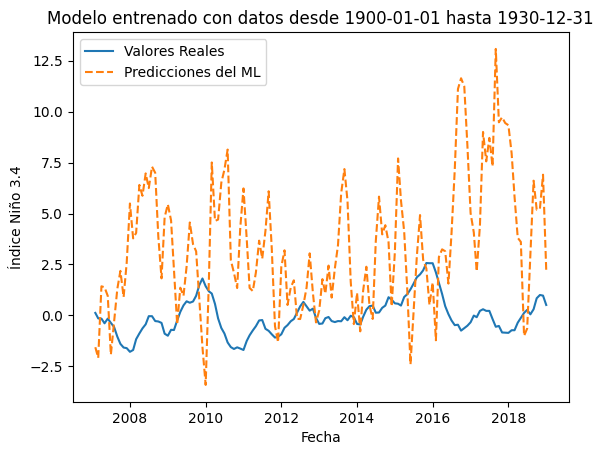

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - loss: 735.2098 - val_loss: 540.3663
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 379.9700 - val_loss: 107.8530
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 113.3930 - val_loss: 26.9530
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 36.7793 - val_loss: 9.2052
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 10.7058 - val_loss: 6.5941
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 6.7112 - val_loss: 3.9145
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 3.5339 - val_loss: 3.3179
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.4966 - val_loss: 2.2979
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.5440 - val_loss: 1.5682
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 1.0773 - val_loss: 1.2407
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.7436 - val_loss: 1.2784
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.

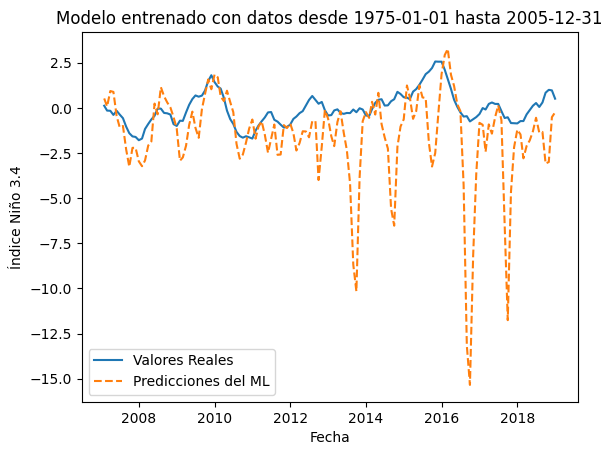

In [4]:
# Definir los periodos de entrenamiento y evaluación
periodos_entrenamiento = [("1900-01-01", "1930-12-31"), ("1975-01-01", "2005-12-31")]
periodo_evaluacion = ("2007-01-01", "2018-12-31")

# Iterar sobre los periodos de entrenamiento definidos
for fecha_inicio_entrenamiento, fecha_fin_entrenamiento in periodos_entrenamiento:
    X_entrenamiento, y_entrenamiento = assemble_basic_predictors_predictands(fecha_inicio_entrenamiento, fecha_fin_entrenamiento, lead_time=1)
    X_prueba, y_prueba = assemble_basic_predictors_predictands(periodo_evaluacion[0], periodo_evaluacion[1], lead_time=1)

    # Dividir los datos en entrenamiento y validación
    X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_entrenamiento, y_entrenamiento, test_size=0.2, random_state=42)

    # Reajustar los datos para la entrada de Conv1D
    X_entrenamiento = X_entrenamiento.reshape((X_entrenamiento.shape[0], X_entrenamiento.shape[1], 1))
    X_validacion = X_validacion.reshape((X_validacion.shape[0], X_validacion.shape[1], 1))
    X_prueba = X_prueba.reshape((X_prueba.shape[0], X_prueba.shape[1], 1))

    # Definir el modelo
    modelo = Sequential()
    modelo.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_entrenamiento.shape[1], 1)))
    modelo.add(Flatten())
    modelo.add(Dense(1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, epochs=50, batch_size=32, validation_data=(X_validacion, y_validacion), verbose=1)

    # Evaluar el modelo en el conjunto de prueba
    predicciones = modelo.predict(X_prueba)
    rmse = np.sqrt(mean_squared_error(y_prueba, predicciones))
    """
    RMSE= Root Mean Squared Error (Error Cuadrático Medio)
    """
    print(f"RMSE para el modelo entrenado con datos desde {fecha_inicio_entrenamiento} hasta {fecha_fin_entrenamiento}: {rmse}")

    # Graficar resultados
    titulo = f"Modelo entrenado con datos desde {fecha_inicio_entrenamiento} hasta {fecha_fin_entrenamiento}"
    plot_nino_time_series(y_prueba, predicciones, titulo)


#**2. Ejercicio de desafío: Manejo de datos: ¿Los algoritmos de aprendizaje automático funcionan mejor con un problema de clasificación o un problema de regresión?**

Convierta el problema de regresión (predicción de un valor continuo) a clasificación (predicción de un valor discreto).  En este caso, el valor continuo es el valor exacto del índice Niño3.4.  

Agrupemos el índice Niño3.4 en dos valores: 0 y 1.  Supongamos que los valores negativos del índice Niño3.4 deben asignarse a 0 y los valores positivos del índice deben asignarse a 1.

### Objetivo del ejercicio:

¡Entrene una red neuronal y un modelo de regresión logística sklearn para predecir 0 o 1 correspondiente al mapeo anterior!  Intente cambiar la función de pérdida de la red neuronal de 'nn. MSELoss' a 'nn. BCEWithLogitsLoss'!

In [5]:
# Cargar datos
def load_enso_indices():
    # ENSO: El Niño-Southern Oscillation (Oscilación del Sur-El Niño)
    """
    Cargar los índices ENSO desde un archivo de texto.

    Devuelve:
        enso_vals (pd.Series): Serie temporal de valores ENSO desde 1870-01-01.
    """
    with open('nino34.long.anom.data.txt') as f:
        line = f.readline()
        enso_vals = []
        while line:
            yearly_enso_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_enso_vals)
            line = f.readline()
    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time, use_pca=False, n_components=32):
    """
    Preparar los predictores básicos y los predictandos para el modelo de predicción.

    Args:
        start_date (str): Fecha de inicio del periodo de datos.
        end_date (str): Fecha de fin del periodo de datos.
        lead_time (int): Tiempo de antelación para la predicción.
        use_pca (bool): Si se debe usar PCA para reducción de dimensionalidad.
        n_components (int): Número de componentes principales a utilizar si use_pca es True.

    Devuelve:
        X (np.ndarray): Matriz de predictores.
        y (pd.Series): Serie temporal de predictandos.
    """
    ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
    sst = ds['sst'].sel(time=slice(start_date, end_date))
    num_time_steps = sst.shape[0]
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0

    if use_pca:
        pca = sklearn.decomposition.PCA(n_components=n_components)
        pca.fit(sst)
        X = pca.transform(sst)
    else:
        X = sst

    start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]

    ds.close()
    return X, y

def binarize_labels(labels):
    """
    Binarizar las etiquetas: convierte los valores positivos a 1 y los valores negativos a 0.

    Args:
        labels (np.ndarray): Array de etiquetas originales.

    Devuelve:
        np.ndarray: Array de etiquetas binarizadas.
    """
    return np.where(labels >= 0, 1, 0)

# Preparar los datos de entrenamiento y prueba
X_train, y_train = assemble_basic_predictors_predictands("1975-01-01", "2005-12-31", lead_time=1)
X_test, y_test = assemble_basic_predictors_predictands("2007-01-01", "2018-12-31", lead_time=1)

# Binarizar las etiquetas
y_train_bin = binarize_labels(y_train)
y_test_bin = binarize_labels(y_test)


In [6]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        """
        Inicializa la red neuronal simple con una capa oculta.

        Args:
            input_dim (int): Dimensión de entrada.
        """
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        """
        Define la pasada hacia adelante en la red neuronal.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Devuelve:
            torch.Tensor: Salida de la red neuronal.
        """
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_network(X_train, y_train, classification=False):
    """
    Entrena una red neuronal simple.

    Args:
        X_train (np.ndarray): Matriz de predictores de entrenamiento.
        y_train (np.ndarray): Array de etiquetas de entrenamiento.
        classification (bool): Si es True, usa una función de pérdida de clasificación binaria.

    Devuelve:
        SimpleNN: Modelo de red neuronal entrenado.
    """
    input_dim = X_train.shape[1]
    model = SimpleNN(input_dim)

    if classification:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    for epoch in range(50):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    return model

# Entrenar la red neuronal para clasificación
model_nn_classification = train_network(X_train, y_train_bin, classification=True)

def evaluate_model(model, X_test, y_test):
    """
    Evalúa un modelo en el conjunto de prueba.

    Args:
        model (SimpleNN): Modelo de red neuronal a evaluar.
        X_test (np.ndarray): Matriz de predictores de prueba.
        y_test (np.ndarray): Array de etiquetas de prueba.

    Devuelve:
        float: Precisión del modelo en el conjunto de prueba.
    """
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    outputs = model(X_test_tensor)
    predictions = torch.sigmoid(outputs).round().detach().numpy()
    accuracy = accuracy_score(y_test, predictions)
    return accuracy

# Evaluar el modelo en el conjunto de prueba
accuracy_nn_classification = evaluate_model(model_nn_classification, X_test, y_test_bin)
print(f"Precisión del Modelo de Clasificación con Red Neuronal: {accuracy_nn_classification}")
print(f"Lo que indica que el modelo predijo correctamente el {accuracy_nn_classification:.2%} de las muestras de prueba.")


Precisión del Modelo de Clasificación con Red Neuronal: 0.8402777777777778
Lo que indica que el modelo predijo correctamente el 84.03% de las muestras de prueba.


In [7]:
# Entrenar el modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train_bin)

# Evaluar el modelo de regresión logística en el conjunto de prueba
predictions_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test_bin, predictions_log_reg)

# Imprimir la precisión del modelo
print(f"Precisión del Modelo de Regresión Logística: {accuracy_log_reg}")
print(f"Lo que indica que el modelo predijo correctamente el {accuracy_log_reg:.2%} de las muestras de prueba.")

Precisión del Modelo de Regresión Logística: 0.7708333333333334
Lo que indica que el modelo predijo correctamente el 77.08% de las muestras de prueba.


# **3. Ejercicio de desafío: ¡Obtenga el mejor algoritmo de pronóstico de ENSO! (Consejo: consulte la combinación entre algoritmos y pruebe el ajuste de hiperparámetros).**

¿Son útiles las redes neuronales más profundas con más capas convolucionales?
Intente cambiar los hiperparámetros de la red neuronal

* tasa de aprendizaje
* la elección del optimizador
* el tamaño de los filtros de convolución
* la cantidad de filtros de convolución
* la cantidad de pesos en las capas completamente conectadas

Existen otros parámetros de preprocesamiento de datos que pueden mejorar el rendimiento de su algoritmo de pronóstico:

* entrenar su modelo de ML en una "porción" de latitud o longitud específica, en lugar de todo el globo
* ¡Combinar predicciones de múltiples algoritmos diferentes! Por ejemplo, podría promediar la predicción de bosques aleatorios, redes neuronales artificiales, redes neuronales convolucionales o cualquier otro modelo de aprendizaje automático.

Recuerde del cuaderno anterior: los modelos con muchos parámetros (es decir, redes neuronales muy profundas o árboles de decisión muy profundos) tienen más probabilidades de tener un sesgo muy bajo y una varianza muy alta: ¡es probable que se sobreajusten!

*¿Desarrollar un sistema de pronóstico Nino3.4 para un plazo de entrega de 5 meses?* Si lo desea, envíe sus resultados al enlace de Kaggle:

Detalles de la competencia de Kaggle: al igual que en la primera celda de código, probaremos nuestro código con datos del 1 de enero de 2007 al 31 de diciembre de 2017. ¡El cargador de datos se reproduce a continuación! Hay 131 pares predictor/predictand entre estas fechas. Por lo tanto, ¡su entrada debe tener exactamente 131 números!

In [8]:
# Cargar los datos del índice Niño 3.4
def load_enso_indices():
    """
    Cargar los índices ENSO desde un archivo de texto.

    Devuelve:
        enso_vals (pd.Series): Serie temporal de valores ENSO desde 1870-01-01.
    """
    with open('nino34.long.anom.data.txt') as f:
        line = f.readline()
        enso_vals = []
        while line:
            yearly_enso_vals = map(float, line.split()[1:])
            enso_vals.extend(yearly_enso_vals)
            line = f.readline()
    enso_vals = pd.Series(enso_vals)
    enso_vals.index = pd.date_range('1870-01-01', freq='MS', periods=len(enso_vals))
    enso_vals.index = pd.to_datetime(enso_vals.index)
    return enso_vals

# Preparar los predictores y predictandos
def assemble_predictors_predictands(start_date, end_date, lead_time, use_pca=False, n_components=32):
    """
    Preparar los predictores y predictandos para el modelo de predicción.

    Args:
        start_date (str): Fecha de inicio del periodo de datos (formato 'YYYY-MM-DD').
        end_date (str): Fecha de fin del periodo de datos (formato 'YYYY-MM-DD').
        lead_time (int): Tiempo de antelación para la predicción en meses.
        use_pca (bool): Si se debe usar PCA para reducción de dimensionalidad.
        n_components (int): Número de componentes principales a utilizar si use_pca es True.

    Devuelve:
        sst (np.ndarray): Matriz de predictores.
        y (pd.Series): Serie temporal de predictandos.
    """
    # Abrir el conjunto de datos NetCDF que contiene las anomalías de temperatura de la superficie del mar (SST)
    ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')

    # Seleccionar el intervalo de tiempo especificado
      #SST: Sea Surface Temperature(Temperatura de la Superficie del Mar)
    sst = ds['sst'].sel(time=slice(start_date, end_date))

    # Verificar la forma de los datos después de cargar los datos globales
    print(f"Forma de los datos SST: {sst.shape}")

    # Convertir los datos a una matriz 2D (tiempo por características)
    num_time_steps = sst.shape[0]
    sst = sst.values.reshape(num_time_steps, -1)
    sst[np.isnan(sst)] = 0  # Rellenar NaNs con ceros

    # Verificar la forma de los datos después de hacer reshape
    print(f"Forma de los datos SST después de reshape: {sst.shape}")

    if use_pca:
        # PCA: Principal Component Analysis (Análisis de Componentes Principales)
        if sst.shape[1] > 0:  # Asegurarse de que hay características disponibles para PCA
            pca = PCA(n_components=n_components)
            sst = pca.fit_transform(sst)  # Aplicar PCA para reducir la dimensionalidad
        else:
            print("No hay características disponibles para PCA. Saltando PCA.")

    # Ajustar las fechas para el tiempo de antelación (lead_time)
    start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time)
    end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)

    # Obtener los valores del índice Niño 3.4 ajustados por el tiempo de antelación
    y = load_enso_indices()[slice(start_date_plus_lead, end_date_plus_lead)]

    ds.close()  # Cerrar el conjunto de datos NetCDF

    return sst, y

# Parámetros del modelo
lead_time = 5  # Tiempo de antelación para la predicción en meses
use_pca = True  # Indicar si se debe usar PCA para reducción de dimensionalidad
n_components = 32  # Número de componentes principales a utilizar si se aplica PCA

# Obtener los datos de entrenamiento y prueba
train_predictors, train_predictands = assemble_predictors_predictands('1975-01-01', '2005-12-31', lead_time, use_pca, n_components)
test_predictors, test_predictands = assemble_predictors_predictands('2007-01-01', '2017-12-31', lead_time, use_pca, n_components)

# Verificar las dimensiones de los datos
print(f"Forma de los predictores de entrenamiento: {train_predictors.shape}")
print(f"Forma de los predictandos de entrenamiento: {train_predictands.shape}")
print(f"Forma de los predictores de prueba: {test_predictors.shape}")
print(f"Forma de los predictandos de prueba: {test_predictands.shape}")


Forma de los datos SST: (372, 180, 360)
Forma de los datos SST después de reshape: (372, 64800)
Forma de los datos SST: (132, 180, 360)
Forma de los datos SST después de reshape: (132, 64800)
Forma de los predictores de entrenamiento: (372, 32)
Forma de los predictandos de entrenamiento: (372,)
Forma de los predictores de prueba: (132, 32)
Forma de los predictandos de prueba: (132,)


In [9]:
# Clase ENSODataset para manejar los datos de predictores y predictandos
class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        """
        Inicializa el conjunto de datos ENSO con predictores y predictandos.

        Args:
            predictors (np.ndarray): Matriz de predictores.
            predictands (np.ndarray): Matriz de predictandos.
        """
        self.predictors = predictors
        self.predictands = predictands

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.

        Returns:
            int: Número de muestras en el conjunto de datos.
        """
        return len(self.predictors)

    def __getitem__(self, idx):
        """
        Devuelve los predictores y predictandos en el índice dado.

        Args:
            idx (int): Índice de la muestra.

        Returns:
            tuple: Predictores y predictandos en el índice dado.
        """
        return self.predictors[idx], self.predictands[idx]

# Clase DeeperNN para definir un modelo de red neuronal profunda
class DeeperNN(nn.Module):
    def __init__(self, input_dim, num_filters=64, filter_size=2, fc_neurons=128):
        """
        Inicializa la red neuronal profunda con capas convolucionales y totalmente conectadas.

        Args:
            input_dim (int): Dimensión de entrada.
            num_filters (int): Número de filtros en las capas convolucionales.
            filter_size (int): Tamaño del kernel de las capas convolucionales.
            fc_neurons (int): Número de neuronas en la capa totalmente conectada.
        """
        super(DeeperNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=filter_size)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=filter_size)
        self.fc1 = nn.Linear(num_filters * (input_dim - 2 * (filter_size - 1)), fc_neurons)
        self.fc2 = nn.Linear(fc_neurons, 1)

    def forward(self, x):
        """
        Define la pasada hacia adelante en la red neuronal.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Salida de la red neuronal.
        """
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_deeper_network(trainloader, learning_rate=0.001, optimizer_type='adam', num_filters=64, filter_size=2, fc_neurons=128, epochs=50):
    """
    Entrena una red neuronal profunda en un conjunto de datos dado.

    Args:
        trainloader (DataLoader): DataLoader para el conjunto de datos de entrenamiento.
        learning_rate (float): Tasa de aprendizaje para el optimizador.
        optimizer_type (str): Tipo de optimizador ('adam' o 'sgd').
        num_filters (int): Número de filtros en las capas convolucionales.
        filter_size (int): Tamaño del kernel de las capas convolucionales.
        fc_neurons (int): Número de neuronas en la capa totalmente conectada.
        epochs (int): Número de épocas para el entrenamiento.

    Returns:
        DeeperNN: Modelo de red neuronal profunda entrenado.
    """
    input_dim = next(iter(trainloader))[0].shape[1]
    model = DeeperNN(input_dim, num_filters=num_filters, filter_size=filter_size, fc_neurons=fc_neurons)

    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Tipo de optimizador no soportado")

    criterion = nn.MSELoss()

    for epoch in range(epochs):
        for batch_X, batch_y in trainloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y.view(-1, 1))
            loss.backward()
            optimizer.step()

    return model

In [10]:
# Clase ENSODataset para manejar los datos de predictores y predictandos
class ENSODataset(Dataset):
    def __init__(self, predictors, predictands):
        """
        Inicializa el conjunto de datos ENSO con predictores y predictandos.

        Args:
            predictors (np.ndarray): Matriz de predictores.
            predictands (pd.Series): Serie de predictandos.
        """
        self.predictors = predictors.astype(np.float32)  # Convertir a float32 para compatibilidad con PyTorch
        self.predictands = predictands.astype(np.float32)  # Convertir a float32 para compatibilidad con PyTorch

    def __len__(self):
        """
        Devuelve la longitud del conjunto de datos.

        Returns:
            int: Número de muestras en el conjunto de datos.
        """
        return len(self.predictors)

    def __getitem__(self, idx):
        """
        Devuelve los predictores y predictandos en el índice dado.

        Args:
            idx (int): Índice de la muestra.

        Returns:
            tuple: Predictores y predictandos en el índice dado.
        """
        return self.predictors[idx], self.predictands.iloc[idx]  # Usar iloc para la serie de predictandos


In [11]:
def train_deeper_network(trainloader, learning_rate=0.001, optimizer_type='adam', num_filters=64, filter_size=2, fc_neurons=128, epochs=50):
    """
    Entrena una red neuronal profunda en un conjunto de datos dado.

    Args:
        trainloader (DataLoader): DataLoader para el conjunto de datos de entrenamiento.
        learning_rate (float): Tasa de aprendizaje para el optimizador.
        optimizer_type (str): Tipo de optimizador ('adam' o 'sgd').
        num_filters (int): Número de filtros en las capas convolucionales.
        filter_size (int): Tamaño del kernel de las capas convolucionales.
        fc_neurons (int): Número de neuronas en la capa totalmente conectada.
        epochs (int): Número de épocas para el entrenamiento.

    Returns:
        DeeperNN: Modelo de red neuronal profunda entrenado.
    """
    # Obtener la dimensión de entrada a partir del DataLoader
    input_dim = next(iter(trainloader))[0].shape[1]

    # Inicializar el modelo DeeperNN
    model = DeeperNN(input_dim, num_filters=num_filters, filter_size=filter_size, fc_neurons=fc_neurons)

    # Seleccionar el optimizador
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("Tipo de optimizador no soportado")

    # Definir el criterio de pérdida
    criterion = nn.MSELoss()

    # Iterar sobre las épocas de entrenamiento
    for epoch in range(epochs):
        for batch_X, batch_y in trainloader:
            # Convertir los datos a float32 y darles la forma adecuada para la entrada de Conv1D
            batch_X = batch_X.view(batch_X.size(0), 1, batch_X.size(1)).float()
            batch_y = batch_y.float()

            # Reiniciar los gradientes del optimizador
            optimizer.zero_grad()

            # Pasada hacia adelante en el modelo
            outputs = model(batch_X)

            # Calcular la pérdida
            loss = criterion(outputs, batch_y.view(-1, 1))

            # Pasada hacia atrás para calcular los gradientes
            loss.backward()

            # Actualizar los parámetros del modelo
            optimizer.step()

    # Devolver el modelo entrenado
    return model

In [12]:
# Crear el conjunto de datos de entrenamiento
train_dataset = ENSODataset(train_predictors, train_predictands)

# Crear el DataLoader para el conjunto de datos de entrenamiento
trainloader = DataLoader(train_dataset, batch_size=10)

# Entrenar el modelo de red neuronal profunda
nn_model = train_deeper_network(trainloader, epochs=50)


In [13]:
# Importar la clase RandomForestRegressor de scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Crear el modelo de Random Forest con 100 árboles (estimadores)
rf_model = RandomForestRegressor(n_estimators=100)

# Entrenar el modelo de Random Forest con los datos de entrenamiento
rf_model.fit(train_predictors, train_predictands)


RandomForestRegressor()

In [14]:
# Obtener predicciones del modelo de Random Forest
rf_predictions = rf_model.predict(test_predictors)

# Crear el conjunto de datos de prueba
test_dataset = ENSODataset(test_predictors, test_predictands)

# Crear el DataLoader para el conjunto de datos de prueba
testloader = DataLoader(test_dataset, batch_size=10)

# Lista para almacenar las predicciones de la red neuronal profunda
nn_predictions = []

# Desactivar el cálculo de gradientes para obtener predicciones
with torch.no_grad():
    for batch_X, _ in testloader:
        # Convertir los datos a float32 y darles la forma adecuada para la entrada de Conv1D
        batch_X = batch_X.view(batch_X.size(0), 1, batch_X.size(1)).float()
        outputs = nn_model(batch_X)  # Obtener las predicciones del modelo
        nn_predictions.extend(outputs.numpy().flatten())  # Almacenar las predicciones en la lista

# Convertir la lista de predicciones a un array de NumPy
nn_predictions = np.array(nn_predictions)

# Promediar las predicciones de ambos modelos
ensemble_predictions = (rf_predictions + nn_predictions) / 2


In [15]:
from sklearn.metrics import mean_squared_error

# Calcular el RMSE del sistema de predicción
rmse_ensemble = np.sqrt(mean_squared_error(test_predictands, ensemble_predictions))

# Imprimir el resultado en español
print(f"RMSE del Modelo de Ensamblaje: {rmse_ensemble}")


RMSE del Modelo de Ensamblaje: 1.0825520032579272


In [16]:
import pandas as pd
import numpy as np

# Crear el DataFrame de sumisión
submission_df = pd.DataFrame()
submission_df['Id'] = np.arange(len(ensemble_predictions))
submission_df['Predicted'] = ensemble_predictions

# Mostrar el resultado con print
print("Primeras 132 filas del DataFrame de sumisión:")
print(submission_df.head(132))

# Guardar el DataFrame como un archivo CSV
submission_df.to_csv('submission.csv', index=False)

# Descargar el archivo CSV
from google.colab import files
#files.download('submission.csv')


Primeras 132 filas del DataFrame de sumisión:
      Id  Predicted
0      0   0.442170
1      1   0.631986
2      2   0.787209
3      3   0.304209
4      4  -0.118298
..   ...        ...
127  127   0.271884
128  128   0.296195
129  129   0.200483
130  130   0.156767
131  131   0.119337

[132 rows x 2 columns]
